In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from sklearn.preprocessing import MinMaxScaler

#Regressoors
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, AdaBoostRegressor 
from xgboost import XGBRegressor

#PCA
from sklearn.decomposition import RandomizedPCA, PCA
#MDS
from sklearn.manifold import MDS
#SNE
from sklearn.manifold import TSNE

#Train Test Split
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error as MSE

import statsmodels.api as sm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, interact_manual

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Вариант 1

Обработать отдельно каждую серию спектров (18,19,20 .03), преобразовать в своем PCA каждую, преобразовать MinMaxScale, объединить полученные датасеты PCA и на нем обучиться

Тестовую выборку точно так же

In [2]:
Data_Dry = pd.read_csv('pca_data_20190318.csv', sep=',')
Data_Dry.drop('Unnamed: 0', axis=1, inplace=True)
Data_SemiSweet = pd.read_csv('pca_data_20190319.csv', sep=',')
Data_SemiSweet.drop('Unnamed: 0', axis=1, inplace=True)
Data_SemiDry = pd.read_csv('pca_data_20190320.csv', sep=',')
Data_SemiDry.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
scaler = MinMaxScaler()
scaler.fit(Data_Dry.drop('pH', axis=1))
Scaled_Data_Dry = pd.DataFrame(scaler.transform(Data_Dry.drop('pH', axis=1)))
Scaled_Data_Dry['pH'] = Data_Dry.pH.values

scaler = MinMaxScaler()
scaler.fit(Data_SemiDry.drop('pH', axis=1))
Scaled_Data_SemiDry = pd.DataFrame(scaler.transform(Data_SemiDry.drop('pH', axis=1)))
Scaled_Data_SemiDry['pH'] = Data_SemiDry.pH.values

scaler = MinMaxScaler()
scaler.fit(Data_SemiSweet.drop('pH', axis=1))
Scaled_Data_SemiSweet = pd.DataFrame(scaler.transform(Data_SemiSweet.drop('pH', axis=1)))
Scaled_Data_SemiSweet['pH'] = Data_SemiSweet.pH.values

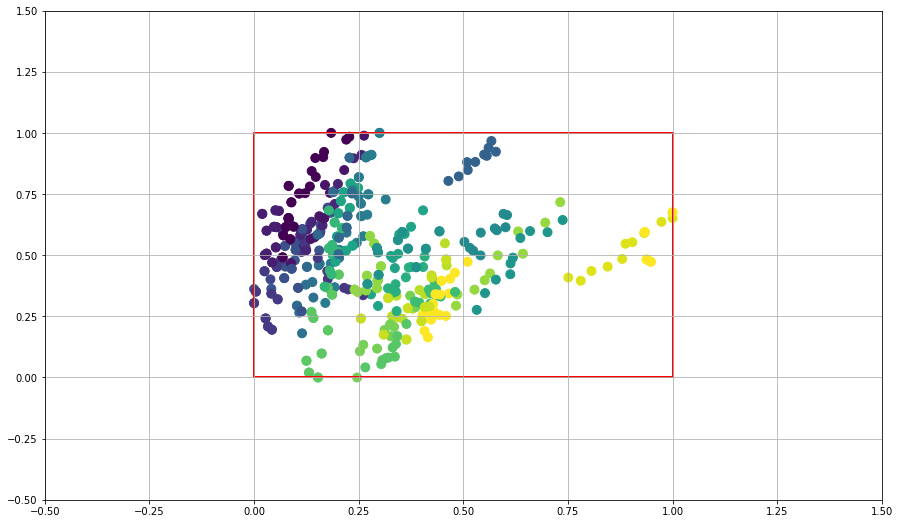

In [4]:
plt.figure(figsize=(15,9))
plt.scatter(Scaled_Data_Dry.iloc[:,0], Scaled_Data_Dry.iloc[:,1], c=Scaled_Data_Dry.pH.values[:], s=80)
plt.scatter(Scaled_Data_SemiDry.iloc[:,0], Scaled_Data_SemiDry.iloc[:,1], c=Scaled_Data_SemiDry.pH.values[:], s=80)
plt.scatter(Scaled_Data_SemiSweet.iloc[:,0], Scaled_Data_SemiSweet.iloc[:,1], c=Scaled_Data_SemiSweet.pH.values[:], s=80)
plt.gca().add_patch(Rectangle((0,0),1,1,linewidth=2,edgecolor='r',facecolor='none'))
plt.xlim(-0.5,1.5)
plt.ylim(-0.5,1.5)
plt.grid()

## Объединим все датасеты

In [5]:
Scaled_PCA_Data = pd.merge(Scaled_Data_Dry, Scaled_Data_SemiDry, how='outer')
Scaled_PCA_Data = pd.merge(Scaled_PCA_Data, Scaled_Data_SemiSweet, how='outer')
Scaled_PCA_Data.sort_values('pH', inplace=True)
Scaled_PCA_Data.head(10)

,0,1,2,pH
459,0.082738,0.783362,0.710005,3.23
458,0.082392,0.652090,0.738460,3.23
129,0.082738,0.783362,0.710005,3.23
128,0.082392,0.652090,0.738460,3.23
127,0.094810,0.616584,0.772978,3.23
126,0.086536,0.565107,0.804363,3.23
125,0.068218,0.491141,0.885110,3.23
123,0.075709,0.614860,0.799281,3.23
122,0.082285,0.649229,0.794647,3.23
121,0.089094,0.716211,0.750140,3.23


Mean Squared Error :  0.0562


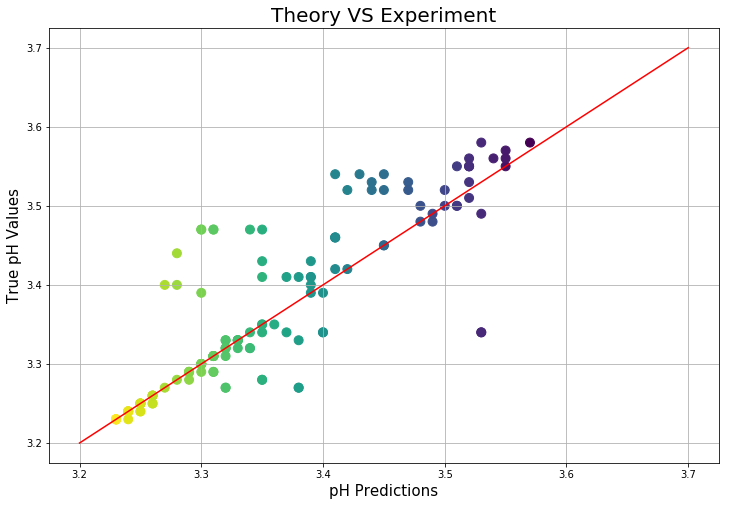

In [6]:
train_data, test_data, train_target, test_target = train_test_split(Scaled_PCA_Data.drop('pH', axis=1),
                                                                    Scaled_PCA_Data.pH,
                                                                   test_size=0.3, random_state=123)
#GradientBoostingRegressor(learning_rate=0.07) 
#LinearRegression() 
#XGBRegressor(max_depth=8, n_estimators=70)

regressor = GradientBoostingRegressor(loss='lad', learning_rate=0.08, n_estimators=200,
                                          max_depth=7, random_state=20, criterion='mse', subsample=0.75) 
regressor.fit(train_data, train_target)
preds = regressor.predict(test_data)
 
#print 'Test Data : ', test_target.values
#print 'Predictions : ', preds.round(2)
#print 'Delta : ', test_target.values - preds.round(2)
print 'Mean Squared Error : ', np.sqrt(MSE(test_target.values, preds)).round(4)

plt.figure(figsize=(12,8))
plt.plot(np.arange(3.2,3.8,0.1), np.arange(3.2,3.8,0.1), c='r')
plt.scatter(preds.round(2) , test_target.values, c=1-(preds-preds.min())/preds.max(), s=80)
plt.xlabel('pH Predictions', fontsize=15)
plt.ylabel('True pH Values', fontsize=15)
plt.title('Theory VS Experiment', fontsize=20)

plt.grid()

In [7]:
regressors = []
mse_array = []
scores = []
for i in range(100):
    train_data, test_data, train_target, test_target = train_test_split(Scaled_PCA_Data.drop('pH', axis=1),
                                                                        Scaled_PCA_Data.pH,
                                                                        test_size=0.3, random_state=i)
    #LinearRegression() 
    #GradientBoostingRegressor(learning_rate=0.07)
    
    regressor = GradientBoostingRegressor(loss='lad', learning_rate=0.08, n_estimators=200,
                                          max_depth=7, random_state=i, criterion='mse', subsample=0.75) 
    
    regressor.fit(train_data, train_target)
    preds = regressor.predict(test_data)
    
    regressors.append(regressor)
    mse_array.append(MSE(test_target.values, preds.round(2)))
    scores.append(regressor.score(test_data, test_target))
    
print 'MSE : ', mse_array[:20]
print 
print 'Corrs : ', scores[:20]
print 
print 'Среднее MSE по 100 случайным выборкам : ', np.sqrt(np.mean(mse_array)).round(4)
print 'Средняя корреляция по 100 случайным выборкам : ', np.mean(scores).round(4)

MSE :  [0.0020942028985507267, 0.0019376811594202913, 0.004184057971014497, 0.0027500000000000003, 0.0021108695652173937, 0.003042028985507251, 0.002261594202898554, 0.002542753623188405, 0.002466666666666666, 0.0027021739130434824, 0.0023072463768115956, 0.002319565217391308, 0.003576811594202902, 0.002245652173913047, 0.002060869565217394, 0.002113043478260871, 0.002245652173913043, 0.003255797101449278, 0.0020847826086956567, 0.0024739130434782626]

Corrs :  [0.8330868037419723, 0.8344855770159498, 0.6353171945210684, 0.7525853441872575, 0.8252565584392513, 0.7339371767609913, 0.795954804705794, 0.8027457720775186, 0.7921517397085377, 0.7735224054534104, 0.7828340976866629, 0.7898188537254967, 0.6978951961152622, 0.8034755496147604, 0.8316056445686646, 0.8194312898235339, 0.8101429061719959, 0.7326656005837758, 0.8101086575494537, 0.789544432579766]

Среднее MSE по 100 случайным выборкам :  0.0494
Средняя корреляция по 100 случайным выборкам :  0.7886


## Загрузим Тестовые данные

In [8]:
Testing_Data = pd.read_csv('Test_for_model_21_03.txt', sep=' ')
Testing_Data.drop(['Channel', 'Wavelength(nm)', 'Current', 'BackGround', 'Unnamed: 44'], axis=1, inplace=True)
Testing_Data = Testing_Data.iloc[:1024,:].T
Testing_Data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Spectrum1,20,35,25,22,27,14,31,20,16,30,...,1101,1102,1071,1077,1088,1103,1063,1058,1086,1056
Spectrum2,0,26,22,16,18,12,26,29,-13,22,...,1066,1068,1064,1065,1039,1078,1057,1068,1018,1012
Spectrum3,7,5,19,-11,15,7,40,27,50,26,...,1028,1041,1026,1033,1051,1026,1031,1014,1046,985
Spectrum4,41,30,25,11,27,5,30,9,38,30,...,1019,1032,1014,1026,1003,1004,990,993,1005,1009
Spectrum5,-3,30,6,48,42,29,22,30,12,15,...,992,993,986,996,994,997,987,982,1005,977
Spectrum6,15,5,28,26,17,25,-10,30,9,42,...,999,957,971,975,1000,993,950,957,960,971
Spectrum7,28,0,3,20,36,18,19,19,27,66,...,982,932,959,986,937,972,942,937,961,932
Spectrum8,13,31,19,-2,0,-3,12,15,45,8,...,942,947,941,963,970,961,905,948,917,907
Spectrum9,5,-4,21,16,28,-7,-7,24,24,37,...,947,948,939,939,955,938,891,892,920,917
Spectrum10,31,13,39,30,15,-10,47,38,30,37,...,1044,1063,1027,1028,1056,1047,1011,1031,1019,999


In [9]:
# Первая строка датафрейма почему то состоит из строк -- исправим
Testing_Data.iloc[0,:] = map(lambda x: float(x), Testing_Data.iloc[0,:].values)

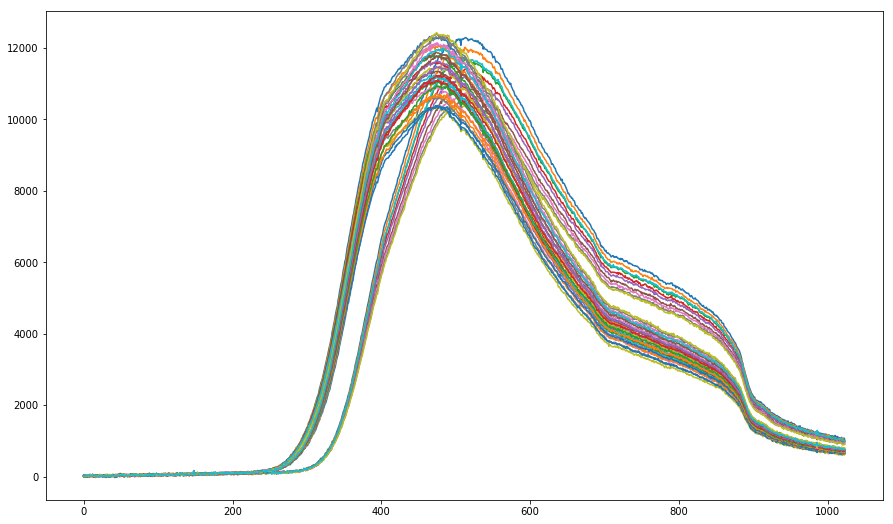

In [10]:
plt.figure(figsize=(15,9))
for i in range(40):
    plt.plot(range(1024) ,Testing_Data.iloc[i,:].values)

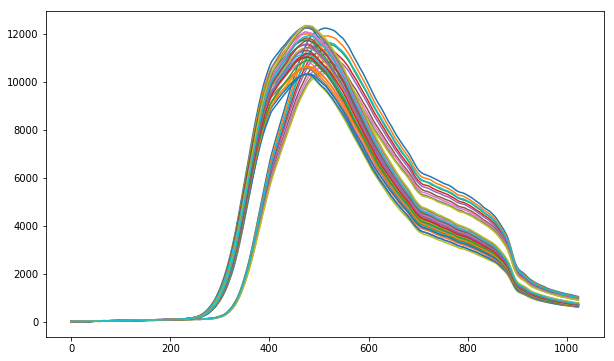

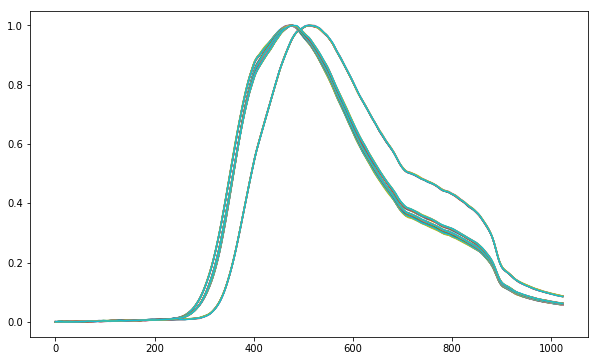

In [11]:
data_lowess_1 = list()
plt.figure(figsize=(10,6))
for i in range(Testing_Data.shape[0]) :
    x = range(Testing_Data.shape[1])
    y = Testing_Data.iloc[i,:].values
    lowess = sm.nonparametric.lowess(y, x, frac=0.015)
    plt.plot(lowess[:,0], lowess[:,1])
    data_lowess_1.append(lowess[:,1])

lowess_Testing_Data = pd.DataFrame(np.array(data_lowess_1))

scaler = MinMaxScaler()
#for i in range(lowess_df.shape[0]):
scaler.fit(lowess_Testing_Data.T)
lowess_Testing_Data = pd.DataFrame(scaler.transform(lowess_Testing_Data.T)).T

plt.figure(figsize=(10,6))
for i in range(40):
    plt.plot(range(1024) ,lowess_Testing_Data.iloc[i,:].values)

In [12]:
pH = np.array([3.38]*10+[3.21]*10+[3.75]*10+[3.58]*10)
lowess_Testing_Data['pH'] = pH

In [13]:
pca_model = PCA(n_components=3)
pca_model.fit(lowess_Testing_Data.drop('pH', axis=1))
PCA_Testing_Data = pd.DataFrame(pca_model.transform(lowess_Testing_Data.drop('pH', axis=1)))
PCA_Testing_Data['pH'] = lowess_Testing_Data.pH.values

scaler = MinMaxScaler()
scaler.fit(PCA_Testing_Data.drop('pH', axis=1))
Scaled_PCA_Testing_Data = pd.DataFrame(scaler.transform(PCA_Testing_Data.drop('pH', axis=1)))
Scaled_PCA_Testing_Data['pH'] = PCA_Testing_Data.pH.values

## Посмотрим куда ложатся точки Тестовой выборки на отмасштабированной плоскости двух главных компонент

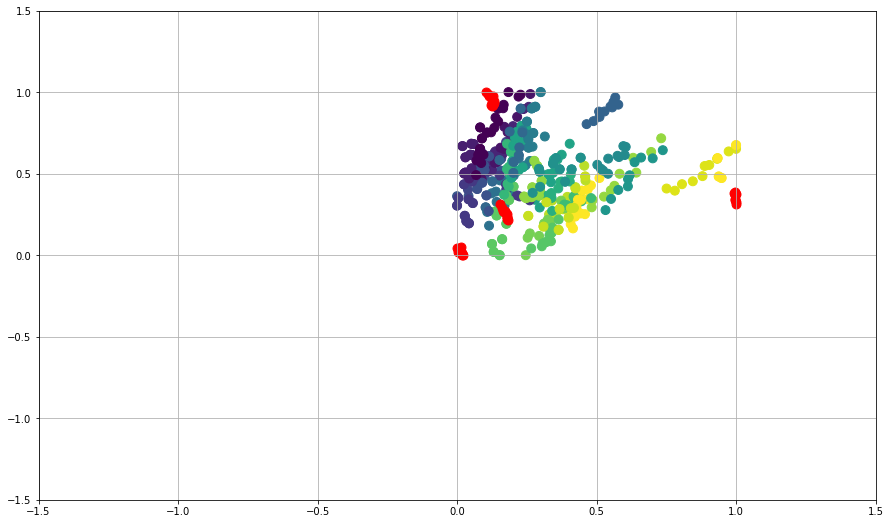

In [14]:
plt.figure(figsize=(15,9))
plt.scatter(Scaled_Data_Dry.iloc[:,0], Scaled_Data_Dry.iloc[:,1], c=Scaled_Data_Dry.pH.values[:], s=80)
plt.scatter(Scaled_Data_SemiDry.iloc[:,0], Scaled_Data_SemiDry.iloc[:,1], c=Scaled_Data_SemiDry.pH.values[:], s=80)
plt.scatter(Scaled_Data_SemiSweet.iloc[:,0], Scaled_Data_SemiSweet.iloc[:,1], c=Scaled_Data_SemiSweet.pH.values[:], s=80)
plt.scatter(Scaled_PCA_Testing_Data.iloc[:,0], Scaled_PCA_Testing_Data.iloc[:,1], c='r', s=80)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.grid()

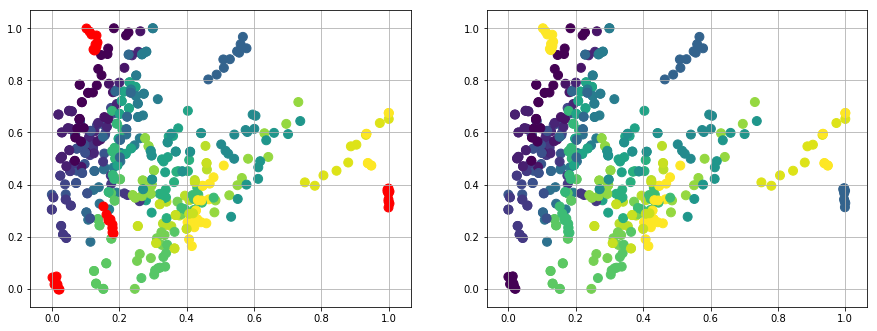

In [15]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.scatter(Scaled_Data_Dry.iloc[:,0], Scaled_Data_Dry.iloc[:,1], c=Scaled_Data_Dry.pH.values[:], s=80)
plt.scatter(Scaled_Data_SemiDry.iloc[:,0], Scaled_Data_SemiDry.iloc[:,1], c=Scaled_Data_SemiDry.pH.values[:], s=80)
plt.scatter(Scaled_Data_SemiSweet.iloc[:,0], Scaled_Data_SemiSweet.iloc[:,1], c=Scaled_Data_SemiSweet.pH.values[:], s=80)
plt.scatter(Scaled_PCA_Testing_Data.iloc[:,0], Scaled_PCA_Testing_Data.iloc[:,1], c='r', s=80)
plt.grid()

plt.subplot(2,2,2)
plt.scatter(Scaled_Data_Dry.iloc[:,0], Scaled_Data_Dry.iloc[:,1], c=Scaled_Data_Dry.pH.values[:], s=80)
plt.scatter(Scaled_Data_SemiDry.iloc[:,0], Scaled_Data_SemiDry.iloc[:,1], c=Scaled_Data_SemiDry.pH.values[:], s=80)
plt.scatter(Scaled_Data_SemiSweet.iloc[:,0], Scaled_Data_SemiSweet.iloc[:,1], c=Scaled_Data_SemiSweet.pH.values[:], s=80)
plt.scatter(Scaled_PCA_Testing_Data.iloc[:,0], Scaled_PCA_Testing_Data.iloc[:,1], c=Scaled_PCA_Testing_Data.pH.values[:], s=80)
plt.grid()

#plt.colorbar()
plt.show()

## Сделаем усредненное по 100 регрессорам предсказание

In [16]:
Predictions = []
for reg in regressors:
    Predictions.append(reg.predict(PCA_Testing_Data.drop('pH', axis=1)))
Predictions = np.array(Predictions)

In [17]:
Prediction = Predictions.mean(axis=0)

MSE :  0.2344


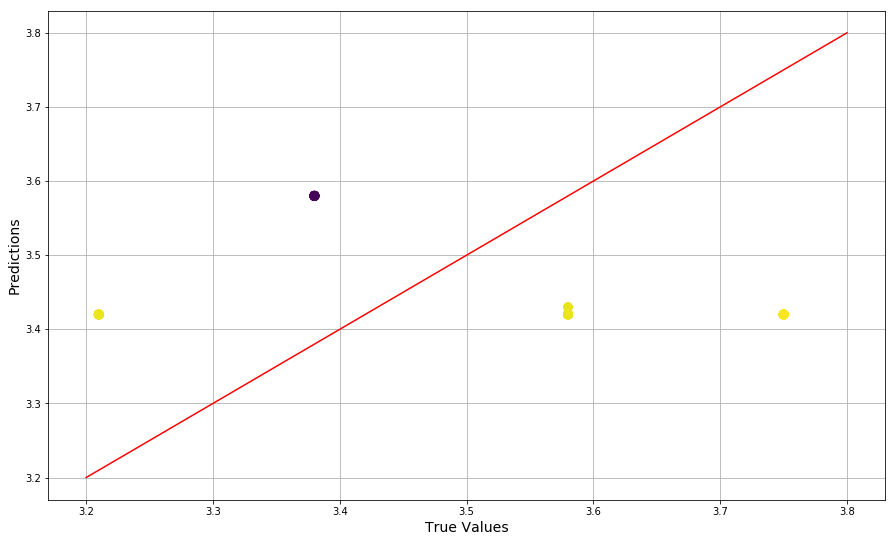

In [20]:
plt.figure(figsize=(15,9))
plt.plot(np.arange(3.2,3.9,0.1), np.arange(3.2,3.9,0.1), c='r')
plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.scatter(PCA_Testing_Data.pH.values, Prediction.round(2) , c=1-(Prediction-Prediction.min())/Prediction.max(), s=80)
plt.grid()
print 'MSE : ', np.sqrt(MSE(Prediction, PCA_Testing_Data.pH.values)).round(4)